## __VGG Net  - MXNet (From Scratch)__

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu()

## __Getting the dataset__

Now lets try a new type of dataset, known as Cifar10. It containes coloured images with shape of (3, 32, 32), note that number of channels is 3 as its a coloured image containing rgb values, and the number of classes are 10 in total

In [38]:
transform = gluon.data.vision.transforms.ToTensor() # this simply reshapes the image according to channel first format(NCHW), and scales it so that images's max and min value is 1 and 0 respectively.

train_mnist = gluon.data.vision.CIFAR10(train = True).transform_first(transform)
test_mnist = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [39]:
image, label = train_mnist[1]
print(image.shape, image.max().asscalar(), image.min().asscalar())
print(label)

(3, 32, 32) 0.99607843 0.019607844
9


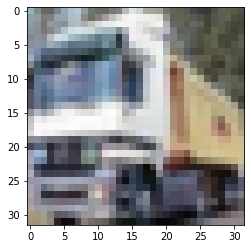

In [40]:
plt.imshow(image.transpose((1, 2, 0)).asnumpy(), 'gray')
plt.show()

## __Defining data loaders__

In [41]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

## __Defining VGG Net Model Architecture__
There are many versions of vgg architecture, below we are gonna workout with vgg 11, as it has 8 convolutional layers and 3 dense layers.

In [49]:
def vggblock(layers, channels):
    block = nn.HybridSequential()
    for _ in range(layers):
        block.add(nn.Conv2D(channels = channels, kernel_size = 3, padding = 1))
        block.add(nn.BatchNorm())
        # batchnorm is originally not the part of vgg net, but we are adding to each block as it speeds up the training
        block.add(nn.Activation('relu'))
    block.add(nn.MaxPool2D(pool_size = 2, strides = 2))
    return block

In [50]:
model = nn.HybridSequential()

model.add(vggblock(layers = 1, channels = 64))
model.add(vggblock(layers = 1, channels = 128))
model.add(vggblock(layers = 2, channels = 256))
model.add(vggblock(layers = 2, channels = 512))
model.add(vggblock(layers = 2, channels = 512))

model.add(nn.Flatten())

model.add(nn.Dense(4096, activation = 'relu'))
model.add(nn.Dropout(0.5))
model.add(nn.Dense(4096, activation = 'relu'))
model.add(nn.Dropout(0.5))
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(relu)
    (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(relu)
    (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  )
  (2): HybridSequential(
    (0): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(r

## __Summarizing the model__

In [51]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 32, 32)               0
            Conv2D-1                             (1, 64, 32, 32)            1792
         BatchNorm-2                             (1, 64, 32, 32)             256
        Activation-3                             (1, 64, 32, 32)               0
         MaxPool2D-4                             (1, 64, 16, 16)               0
            Conv2D-5                            (1, 128, 16, 16)           73856
         BatchNorm-6                            (1, 128, 16, 16)             512
        Activation-7                            (1, 128, 16, 16)               0
         MaxPool2D-8                              (1, 128, 8, 8)               0
            Conv2D-9                              (1, 256, 8, 8)          295168
        BatchNorm-10        

## __Visualizing model architecture__

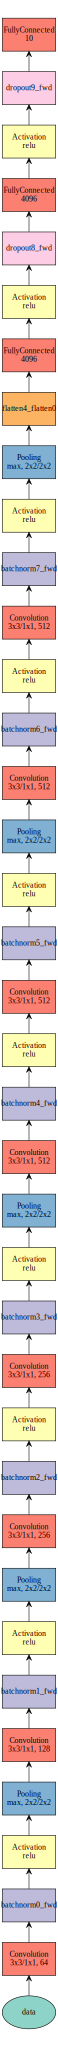

In [52]:
mx.viz.plot_network(model(mx.sym.var(name = 'data')))

By hybridizing the model becomes almost 1.5x fast, as it converts dynamically defined model in to static graph. Its a really cool feature that MXNet provides

In [53]:
model.hybridize()

## __Defining our objective loss and optimizer__

In [54]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

## __Training the model__

In [55]:
epochs = 10
batches = len(train_data)
acc = mx.metric.Accuracy()

for epoch in range(epochs):
    acc.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        acc.update(labels, outputs)
    
    print(f'Epoch: {epoch + 1} | Loss: {cum_loss.asscalar()/batches:.5f} | Training Accuracy: {acc.get()[1]:.5f}')

Epoch: 1 | Loss: 2.03419 | Training Accuracy: 0.19000
Epoch: 2 | Loss: 1.62698 | Training Accuracy: 0.36566
Epoch: 3 | Loss: 1.26235 | Training Accuracy: 0.56012
Epoch: 4 | Loss: 1.01815 | Training Accuracy: 0.65746
Epoch: 5 | Loss: 0.83747 | Training Accuracy: 0.71998
Epoch: 6 | Loss: 0.71464 | Training Accuracy: 0.76320
Epoch: 7 | Loss: 0.64805 | Training Accuracy: 0.79212
Epoch: 8 | Loss: 0.52588 | Training Accuracy: 0.83078
Epoch: 9 | Loss: 0.54991 | Training Accuracy: 0.82610
Epoch: 10 | Loss: 0.44426 | Training Accuracy: 0.86008


## __Testing the model__

In [56]:
acc.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    acc.update(labels, outputs)
acc.get()

('accuracy', 0.7935)